In [1]:
import os
import shutil
import torch
import torch.nn as nn
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from transformers import ViTForImageClassification, ViTConfig
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# Paths
data_folder = './dataset-2'  # Path to the 'leaves' folder
output_folder = './split-dataset-2' # Output folder for the split dataset

In [3]:
# train_ratio = 0.7
# val_ratio = 0.15
# test_ratio = 0.15

# for split in ['train', 'val', 'test']:
#     for class_name in ['maize', 'turmeric']:
#         split_dir = os.path.join(output_folder, split, class_name)
#         os.makedirs(split_dir, exist_ok=True)

# for class_name in ['maize', 'turmeric']:
#     class_folder = os.path.join(data_folder, class_name)
#     images = os.listdir(class_folder)
#     num_images = len(images)

#     # Shuffle and split
#     random.seed(42)  # For reproducibility
#     random.shuffle(images)  # Shuffle the images

#     train_end = int(train_ratio * num_images)
#     val_end = train_end + int(val_ratio * num_images)

#     train_images = images[:train_end]
#     val_images = images[train_end:val_end]
#     test_images = images[val_end:]

#     # Move images to corresponding folders with progress bars
#     print(f"\nCopying images for class '{class_name}'...")

#     # Train images
#     print("Copying train images...")
#     for image in tqdm(train_images, desc=f"Train ({class_name})", unit="image"):
#         shutil.copy(os.path.join(class_folder, image), os.path.join(output_folder, 'train', class_name, image))

#     # Validation images
#     print("Copying validation images...")
#     for image in tqdm(val_images, desc=f"Validation ({class_name})", unit="image"):
#         shutil.copy(os.path.join(class_folder, image), os.path.join(output_folder, 'val', class_name, image))

#     # Test images
#     print("Copying test images...")
#     for image in tqdm(test_images, desc=f"Test ({class_name})", unit="image"):
#         shutil.copy(os.path.join(class_folder, image), os.path.join(output_folder, 'test', class_name, image))

# print("Dataset split complete.")


In [4]:
# Training parameters
image_size = 224  # ViT typically uses 224x224 images
batch_size = 48
num_classes = 2  # Number of classes: maize and turmeric
learning_rate = 0.00001
num_epochs = 50

In [5]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# Dataset and DataLoader
train_dataset = datasets.ImageFolder(os.path.join(output_folder, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(output_folder, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(output_folder, 'test'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
config = ViTConfig(
    hidden_size=768,            # Increase hidden size from 768 to 1024 for a more expressive model
    num_attention_heads=12,      # Increase the number of attention heads from 12 to 16
    num_hidden_layers=16,        # Increase the number of hidden layers from 16 to 20
    image_size=image_size,       # Keep the image size the same (224x224)
    patch_size=16,                # Reduce patch size from 16 to 8 for a finer representation
    num_labels=num_classes,      # Number of output classes remains the same
    dropout_rate=0.05           # Increase dropout rate to 0.2 for better regularizatiozz
)

In [8]:
# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Now you can use 'device' in your model and tensor operations
print(f"Using device: {device}")


Using device: cuda


In [9]:
# Initialize the ViT model for classification
model = ViTForImageClassification(config)
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [10]:
# Training loop
val_accuracies = []
train_losses = [] 
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images).logits
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Training Loss: {avg_loss:.4f}")
    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")
    val_accuracies.append(accuracy)

print("Training complete.")

Epoch 1/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [08:13<00:00,  1.20s/it]


Training Loss: 0.2047
Validation Accuracy: 93.55%


Epoch 2/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [05:22<00:00,  1.27it/s]


Training Loss: 0.1335
Validation Accuracy: 95.83%


Epoch 3/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [05:22<00:00,  1.28it/s]


Training Loss: 0.1023
Validation Accuracy: 95.05%


Epoch 4/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [05:22<00:00,  1.27it/s]


Training Loss: 0.0785
Validation Accuracy: 97.87%


Epoch 5/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0677
Validation Accuracy: 97.91%


Epoch 6/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [05:22<00:00,  1.27it/s]


Training Loss: 0.0628
Validation Accuracy: 98.03%


Epoch 7/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [05:22<00:00,  1.27it/s]


Training Loss: 0.0568
Validation Accuracy: 96.54%


Epoch 8/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0550
Validation Accuracy: 97.91%


Epoch 9/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0496
Validation Accuracy: 98.41%


Epoch 10/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0464
Validation Accuracy: 98.41%


Epoch 11/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:43<00:00,  1.20it/s]


Training Loss: 0.0432
Validation Accuracy: 98.46%


Epoch 12/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0415
Validation Accuracy: 97.18%


Epoch 13/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:22<00:00,  1.27it/s]


Training Loss: 0.0379
Validation Accuracy: 98.01%


Epoch 14/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:22<00:00,  1.27it/s]


Training Loss: 0.0327
Validation Accuracy: 98.58%


Epoch 15/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:22<00:00,  1.27it/s]


Training Loss: 0.0305
Validation Accuracy: 98.74%


Epoch 16/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0317
Validation Accuracy: 98.65%


Epoch 17/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:22<00:00,  1.27it/s]


Training Loss: 0.0240
Validation Accuracy: 98.70%


Epoch 18/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:22<00:00,  1.27it/s]


Training Loss: 0.0269
Validation Accuracy: 98.65%


Epoch 19/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0202
Validation Accuracy: 98.74%


Epoch 20/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:22<00:00,  1.27it/s]


Training Loss: 0.0196
Validation Accuracy: 96.71%


Epoch 21/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:22<00:00,  1.27it/s]


Training Loss: 0.0169
Validation Accuracy: 98.72%


Epoch 22/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:22<00:00,  1.27it/s]


Training Loss: 0.0184
Validation Accuracy: 98.70%


Epoch 23/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0158
Validation Accuracy: 98.74%


Epoch 24/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:22<00:00,  1.27it/s]


Training Loss: 0.0124
Validation Accuracy: 98.44%


Epoch 25/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:22<00:00,  1.27it/s]


Training Loss: 0.0128
Validation Accuracy: 98.82%


Epoch 26/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0102
Validation Accuracy: 98.74%


Epoch 27/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0113
Validation Accuracy: 98.93%


Epoch 28/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0082
Validation Accuracy: 98.60%


Epoch 29/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:24<00:00,  1.27it/s]


Training Loss: 0.0127
Validation Accuracy: 98.72%


Epoch 30/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0103
Validation Accuracy: 98.60%


Epoch 31/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0057
Validation Accuracy: 98.79%


Epoch 32/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0083
Validation Accuracy: 98.67%


Epoch 33/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0113
Validation Accuracy: 98.72%


Epoch 34/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0057
Validation Accuracy: 98.53%


Epoch 35/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0125
Validation Accuracy: 98.67%


Epoch 36/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0062
Validation Accuracy: 98.86%


Epoch 37/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0079
Validation Accuracy: 98.60%


Epoch 38/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0036
Validation Accuracy: 98.65%


Epoch 39/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0085
Validation Accuracy: 98.70%


Epoch 40/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0034
Validation Accuracy: 98.72%


Epoch 41/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0070
Validation Accuracy: 98.84%


Epoch 42/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0063
Validation Accuracy: 98.63%


Epoch 43/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0005
Validation Accuracy: 98.93%


Epoch 44/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0000
Validation Accuracy: 98.96%


Epoch 45/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0000
Validation Accuracy: 98.93%


Epoch 46/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0000
Validation Accuracy: 98.93%


Epoch 47/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0000
Validation Accuracy: 98.93%


Epoch 48/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0000
Validation Accuracy: 98.96%


Epoch 49/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:23<00:00,  1.27it/s]


Training Loss: 0.0000
Validation Accuracy: 98.98%


Epoch 50/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:22<00:00,  1.27it/s]


Training Loss: 0.0000
Validation Accuracy: 98.93%
Training complete.


In [11]:
import pandas as pd
val_df = pd.DataFrame({
    "Epoch": list(range(1, num_epochs + 1)),
    "Validation Accuracy": val_accuracies,
    "Training Loss": train_losses
})

# Append to a CSV file (ensure this file name is unique for each model)
val_df.to_csv("model-1_val_accuracy.csv", mode='a', index=False, header=not pd.io.common.file_exists("model-1_val_accuracy.csv"))

In [12]:
# Evaluation on test set
model.eval()
true_labels = []
predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).logits
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())


In [13]:
 # Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')


# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9882
Precision: 0.9881
Recall: 0.9882
F1 Score: 0.9881


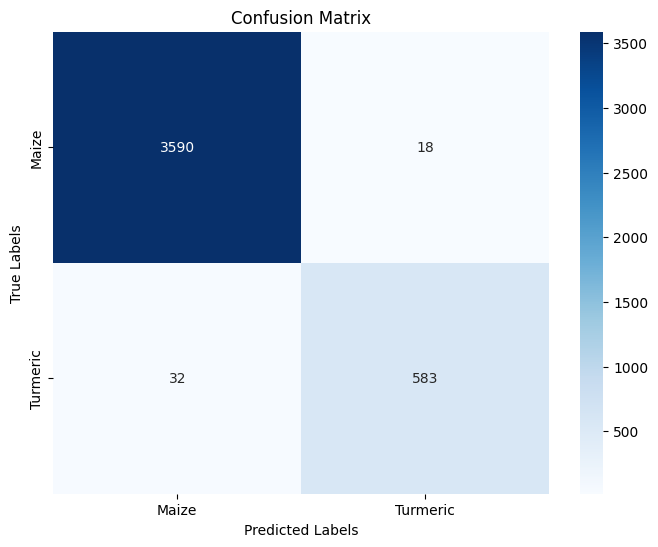

In [14]:
# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Maize', 'Turmeric'], yticklabels=['Maize', 'Turmeric'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [15]:
# In each model notebook, at the end of your metrics calculation, do this:
import pandas as pd

# Example metrics for Model 1
vit_metrics = {
    "Model": "ViT",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
}

metrics_df = pd.DataFrame([vit_metrics])

# Append to CSV file
metrics_df.to_csv("model_metrics-2.csv", mode='a', index=False, header=not pd.io.common.file_exists("model_metrics-2.csv"))
